In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2
import math
import copy
import os
from tqdm import tqdm_notebook

from PIL import Image
from math import cos, sin, radians

Mounted at /content/drive


## 변환 순서
1. image 회전변환
2. obb label 회전변환, obb -> seg로 포맷변환

## Displaying our image

1.   항목 추가
2.   항목 추가



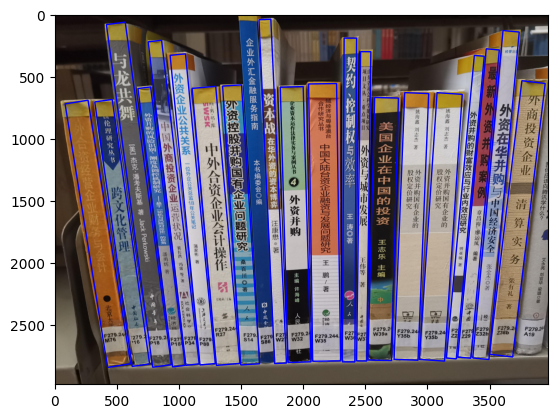

In [ ]:
file_name = '00001.'
img_path = '/content/drive/MyDrive/big project/yolov8/dataset/train/images/'
label_path = '/content/drive/MyDrive/big project/yolov8/dataset/train/labelTxt_obb/' # obb 라벨에서부터 변환 시작
image = Image.open(img_path+file_name+'jpg')
width,height = image.size
im = np.array(image, dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Load OBB label
rects = []
with open(label_path+file_name+'txt','r') as f:
    for box in f :
        x1,y1,x2,y2,x3,y3,x4,y4,_,_ = box.strip().split()
        points = [[x1, y1], [x2, y2], [x3, y3], [x4,y4]]
        polygon = patches.Polygon(points, closed=True, linewidth=1, edgecolor='b', facecolor='none')
        plt.gca().add_patch(polygon)
        plt.axis('scaled')

plt.show()

## 이미지 회전

In [ ]:
def rotate_image_with_point(file_name, image, angle, bboxes):
    # 이미지의 중심점 계산
    height, width = image.shape[:2]
    # 회전 변환 행렬 생성
    rotation_matrix = cv2.getRotationMatrix2D((width/2,height/2), angle, 1)
    # 회전 중심을 이미지 중심으로 조정
    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_width = int((height * sin) + (width * cos))
    new_height = int((height * cos) + (width * sin))
    rotation_matrix[0, 2] += (new_width / 2) - (width / 2)
    rotation_matrix[1, 2] += (new_height / 2) - (height / 2)
    # 이미지 회전
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_width, new_height)) # 새 중심이 포함된 회전 변환 행렬
    # 백그라운드 이미지 라면 rotated_image만 return
    if file_name.startswith('b'):
        return rotated_image
    # OBB 좌표값 회전 변환
    rotated_bboxes = []
    for bbox in bboxes:
        rotated_bbox = [rotate_point(point, angle, (new_width/2, new_height/2), (width/2, height/2)) for point in bbox]
        rotated_bboxes.append(rotated_bbox)
    return rotated_image, rotated_bboxes, new_width, new_height

def rotate_point(point, angle, new_center, center):
    # 각도를 라디안으로 변환
    angle_rad = math.radians(-angle)
    x,y = point
    ncx,ncy = new_center
    cx,cy = center
    # 회전 변환 수식
    new_x = (x - cx) * math.cos(angle_rad) - (y - cy) * math.sin(angle_rad) + ncx
    new_y = (x - cx) * math.sin(angle_rad) + (y - cy) * math.cos(angle_rad) + ncy
    return [new_x, new_y]

# 이미지 로드
image = np.array(Image.open(img_path+file_name+'jpg'), dtype=np.uint8)

# Load rotated OBB label
bboxes = []
with open(label_path+file_name+'txt','r') as f:
    for bbox in f :
        x1,y1,x2,y2,x3,y3,x4,y4,_,_ = bbox.strip().split()
        x1,y1,x2,y2,x3,y3,x4,y4 = map(float,[x1,y1,x2,y2,x3,y3,x4,y4])
        bboxes.append([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])

# 결과 이미지 확인
fig,ax = plt.subplots(1)

# 이미지와 좌표값 회전 변환
angle = 10
rotated_image, rotated_bboxes, new_width, new_height = rotate_image_with_point(image, angle, bboxes)

# 이미지와 회전된 좌표값 출력
ax.imshow(rotated_image)
for rotated_bbox in rotated_bboxes:
    polygon = patches.Polygon(rotated_bbox, closed=True, linewidth=0.5, edgecolor='b', facecolor='none')
    plt.gca().add_patch(polygon)

# Save the processed image
cv2.imwrite('/content/drive/MyDrive/big project/yolov8/output_image.jpg', rotated_image)

# 결과 이미지 출력
plt.show()

NameError: ignored

In [ ]:
# rbbox label 입력
with open('/content/drive/MyDrive/big project/yolov8/test.txt','w') as f:
    for rotated_bbox in rotated_bboxes:
        line = '0 '
        for x,y in rotated_bbox:
            line += f'{x/new_width} {y/new_height} '
        f.write(line+'\n')

In [ ]:
def load_and_draw_bounding_box(filepath, img_path):
    # Load image
    im = np.array(Image.open(img_path), dtype=np.uint8)
    new_width,new_height = im.shape[1], im.shape[0]
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    with open(filepath, 'r') as f:
        for line in f:
            _,x1,y1,x2,y2,x3,y3,x4,y4 = line.strip().split()
            corners = [[float(x1)*new_width,float(y1)*new_height],[float(x2)*new_width,float(y2)*new_height],[float(x3)*new_width,float(y3)*new_height],[float(x4)*new_width,float(y4)*new_height]]
            # Create a Rectangle patch
            rect = patches.Polygon(corners, linewidth=1, edgecolor='r', facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)

    plt.show()

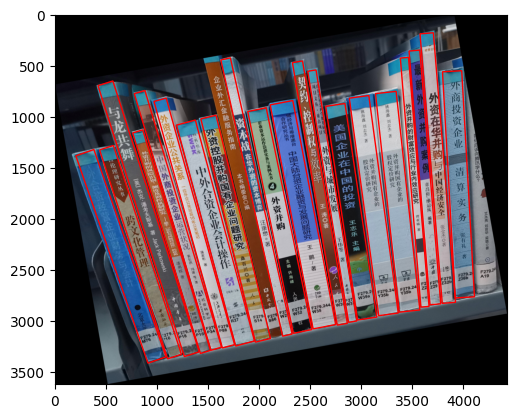

In [ ]:
load_and_draw_bounding_box('/content/drive/MyDrive/big project/yolov8/test.txt', '/content/drive/MyDrive/big project/yolov8/output_image.jpg')

## train set 변환

In [ ]:
# train set 변환
img_path = '/content/drive/MyDrive/big project/yolov8/dataset/train/images/'
obb_label_path = '/content/drive/MyDrive/big project/yolov8/dataset/train/labelTxt_obb/'
seg_label_path = '/content/drive/MyDrive/big project/yolov8/dataset/train/labels/'

# 파일별 변환 진행
for file_name in tqdm_notebook(os.listdir(img_path)):
    file_name = file_name[:-3]

    # 이미지 불러오기
    image = np.array(Image.open(img_path+file_name+'jpg'), dtype=np.uint8)

    # 백그라운드 이미지라면 rotated_image만 저장
    if file_name.startswith('b'):
        for angle in [-90,-67,-45,-22,22,45,67,90]:
            # 이미지와 좌표값 회전 변환
            rotated_image = rotate_image_with_point(file_name, image, angle, bboxes)

            # 회전된 이미지 저장
            cv2.imwrite(img_path+f'rot{angle}_{file_name}jpg', rotated_image)

    else :
        # 기존 OBB 라벨 불러오기
        bboxes = []
        with open(obb_label_path+file_name+'txt','r') as f:
            for bbox in f :
                x1,y1,x2,y2,x3,y3,x4,y4,_,_ = bbox.strip().split()
                x1,y1,x2,y2,x3,y3,x4,y4 = map(float,[x1,y1,x2,y2,x3,y3,x4,y4])
                bboxes.append([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])

        for angle in [-90,-67,-45,-22,22,45,67,90]:
            # 이미지와 좌표값 회전 변환
            rotated_image, rotated_bboxes, new_width, new_height = rotate_image_with_point(file_name, image, angle, bboxes)

            # 회전된 이미지 저장
            cv2.imwrite(img_path+f'rot{angle}_{file_name}jpg', rotated_image)

            # 새로운 라벨
            with open(seg_label_path+f'rot{angle}_{file_name}txt','w') as f:
                # rbbox label 입력
                for rotated_bbox in rotated_bboxes:
                    line = '0 '
                    # 좌표값 정규화
                    for x,y in rotated_bbox:
                        line += f'{x/new_width} {y/new_height} '
                    f.write(line+'\n')

<ipython-input-388-34e0d3370ca3>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file_name in tqdm_notebook(os.listdir(img_path)):


  0%|          | 0/195 [00:00<?, ?it/s]

In [ ]:
# 이미지가 1755개, 라벨이 1620개 여야함
print(len(os.listdir('/content/drive/MyDrive/big project/yolov8/dataset/train/images')))
print(len(os.listdir('/content/drive/MyDrive/big project/yolov8/dataset/train/labels')))

1755
1620


In [ ]:
# 회전된 라벨, 이미지 확인
for file_name in ['rot90_00001.', 'rot-45_00002.','rot22_00592.','rot-22_00593.','rot67_01001.', 'rot-67_01005.', 'rot45_01013.', 'rot-45_01014.', 'rot-45_01015.']:
    load_and_draw_bounding_box(f'/content/drive/MyDrive/big project/yolov8/dataset/train/labels/{file_name}txt', f'/content/drive/MyDrive/big project/yolov8/dataset/train/images/{file_name}jpg')

Output hidden; open in https://colab.research.google.com to view.

## Valid set 변환

In [ ]:
img_path = '/content/drive/MyDrive/big project/yolov8/dataset/valid/images/'
obb_label_path = '/content/drive/MyDrive/big project/yolov8/dataset/valid/labelTxt_obb/'
seg_label_path = '/content/drive/MyDrive/big project/yolov8/dataset/valid/labels/'

# 파일별 변환 진행
for file_name in tqdm_notebook(os.listdir(img_path)):
    file_name = file_name[:-3]

    # 이미지 불러오기
    image = np.array(Image.open(img_path+file_name+'jpg'), dtype=np.uint8)

    # 백그라운드 이미지라면 rotated_image만 저장
    if file_name.startswith('b'):
        for angle in [-90,-67,-45,-22,22,45,67,90]:
            # 이미지와 좌표값 회전 변환
            rotated_image = rotate_image_with_point(file_name, image, angle, bboxes)

            # 회전된 이미지 저장
            cv2.imwrite(img_path+f'rot{angle}_{file_name}jpg', rotated_image)

    else :
        # 기존 OBB 라벨 불러오기
        bboxes = []
        with open(obb_label_path+file_name+'txt','r') as f:
            for bbox in f :
                x1,y1,x2,y2,x3,y3,x4,y4,_,_ = bbox.strip().split()
                x1,y1,x2,y2,x3,y3,x4,y4 = map(float,[x1,y1,x2,y2,x3,y3,x4,y4])
                bboxes.append([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])

        for angle in [-90,-67,-45,-22,22,45,67,90]:
            # 이미지와 좌표값 회전 변환
            rotated_image, rotated_bboxes, new_width, new_height = rotate_image_with_point(file_name, image, angle, bboxes)

            # 회전된 이미지 저장
            cv2.imwrite(img_path+f'rot{angle}_{file_name}jpg', rotated_image)

            # 새로운 라벨
            # with open(seg_label_path+f'rot{angle}_{file_name}txt','w') as f:
            #     # rbbox label 입력
            #     for rotated_bbox in rotated_bboxes:
            #         line = '0 '
            #         # 좌표값 정규화
            #         for x,y in rotated_bbox:
            #             line += f'{x/new_width} {y/new_height} '
            #         f.write(line+'\n')

<ipython-input-14-0b900dc4520b>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file_name in tqdm_notebook(os.listdir(img_path)):


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
len(os.listdir('/content/drive/MyDrive/big project/yolov8/dataset/valid/images'))

450

In [ ]:
# 이미지가 450개, 라벨이 450개 여야함
print(len(os.listdir('/content/drive/MyDrive/big project/yolov8/dataset/valid/images')))
print(len(os.listdir('/content/drive/MyDrive/big project/yolov8/dataset/valid/labels')))

450
450


In [ ]:
# 회전된 라벨, 이미지 확인
for file_name in ['rot90_00101.', 'rot-45_00214.','rot22_00398.','rot-22_00401.','rot67_00513.', 'rot-67_00515.', 'rot45_01016.', 'rot-45_01017.', 'rot67_01025.']:
    load_and_draw_bounding_box(f'/content/drive/MyDrive/big project/yolov8/dataset/valid/labels/{file_name}txt', f'/content/drive/MyDrive/big project/yolov8/dataset/valid/images/{file_name}jpg')

Output hidden; open in https://colab.research.google.com to view.